# Group 3 - Project 1 - Air Pollution in the United States

### Introduction

In [75]:
'''
Requirement: Google API key gkey in config.py
'''

# import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import gmaps
from config import gkey
from pprint import pprint

from scipy import stats
from scipy.stats import linregress

# Import Data (Smaller test data to start with)
file_path = os.path.join('..', 'Project1', 'data-society-us-air-pollution-data', 'uspollution', 'pollution_us_2000_2016.csv')
raw_data = pd.read_csv(file_path)

### Data Exploration and Cleanup

In [2]:
# Examine Colume datae type
display(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 29 columns):
Unnamed: 0           int64
State Code           int64
County Code          int64
Site Num             int64
Address              object
State                object
County               object
City                 object
Date Local           object
NO2 Units            object
NO2 Mean             float64
NO2 1st Max Value    float64
NO2 1st Max Hour     int64
NO2 AQI              int64
O3 Units             object
O3 Mean              float64
O3 1st Max Value     float64
O3 1st Max Hour      int64
O3 AQI               int64
SO2 Units            object
SO2 Mean             float64
SO2 1st Max Value    float64
SO2 1st Max Hour     int64
SO2 AQI              float64
CO Units             object
CO Mean              float64
CO 1st Max Value     float64
CO 1st Max Hour      int64
CO AQI               float64
dtypes: float64(10), int64(10), object(9)
memory usage: 386.5+ MB


None

In [3]:
# Examine the shape of the dataset set
data_dem = raw_data.shape
num_raws = data_dem[0]
num_cols = data_dem[1]
print(f"This air pollution dataset has {num_raws} rows of data, and each row has {num_cols} columns.")

This air pollution dataset has 1746661 rows of data, and each row has 29 columns.


In [4]:
# How Many Unique States?
state_uni = raw_data["State"].unique()
print(f"There are {len(state_uni)} states in the dataset.")

There are 47 states in the dataset.


In [5]:
# We notice some states are missing. Identify missing states.
'''source: https://gist.github.com/rugbyprof/76575b470b6772ce8fa0c49e23931d97'''
state_list = {"AL":"Alabama"      ,"AK":"Alaska"     ,"AZ":"Arizona"       ,"AR":"Arkansas"     ,"CA":"California",
              "CO":"Colorado"     ,"CT":"Connecticut","DE":"Delaware"      ,"FL":"Florida"      ,"GA":"Georgia"   ,
              "HI":"Hawaii"       ,"ID":"Idaho"      ,"IL":"Illinois"      ,"IN":"Indiana"      ,"IA":"Iowa"      ,
              "KS":"Kansas"       ,"KY":"Kentucky"   ,"LA":"Louisiana"     ,"ME":"Maine"        ,"MD":"Maryland"  ,
              "MA":"Massachusetts","MI":"Michigan"   ,"MN":"Minnesota"     ,"MS":"Mississippi"  ,"MO":"Missouri"  ,
              "MT":"Montana"      ,"NE":"Nebraska"   ,"NV":"Nevada"        ,"NH":"New Hampshire","NJ":"New Jersey",
              "NM":"New Mexico"   ,"NY":"New York"   ,"NC":"North Carolina","ND":"North Dakota" ,"OH":"Ohio"      ,
              "OK":"Oklahoma"     ,"OR":"Oregon"     ,"PA":"Pennsylvania"  ,"RI":"Rhode Island" ,"SC":"South Carolina",
              "SD":"South Dakota" ,"TN":"Tennessee"  ,"TX":"Texas"         ,"UT":"Utah"         ,"VT":"Vermont",
              "VA":"Virginia"     ,"WA":"Washington" ,"WV":"West Virginia" ,"WI":"Wisconsin"    ,"WY":"Wyoming",
              "DC":"District Of Columbia",
         } 
missing_states = []
for itm in state_list:
    if state_list[itm] not in state_uni:
        missing_states.append(state_list[itm])
        
print('Missing states: ', missing_states)

Missing states:  ['Mississippi', 'Montana', 'Nebraska', 'Vermont', 'West Virginia']


In [6]:
# Adding the unique states in the dataset plus missing states equal to 52. Something is not right.
pprint(np.sort(state_uni))

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Missouri', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia',
       'Washington', 'Wisconsin', 'Wyoming'], dtype=object)


In [7]:
# Drop Country of Mexico
trim_data = raw_data.loc[raw_data['State'] != 'Country Of Mexico']

In [8]:
# Keep only NO2 Mean Data
col_list = ['State', 'Date Local', 'NO2 Mean']
trim_data = trim_data[col_list]

# Examine whether we have any NaN in the data
for col in col_list:
    print(col, ': ', trim_data.loc[trim_data[col].isna()].shape[0])

State :  0
Date Local :  0
NO2 Mean :  0


In [11]:
# Examine any duplicates
trim_data = trim_data.drop_duplicates(subset = col_list)

In [12]:
# Add Year Column
trim_data['year'] = trim_data['Date Local'].str[:4].astype(int)

# Add Month Column
trim_data['month'] = trim_data['Date Local'].str[5:7].astype(int)

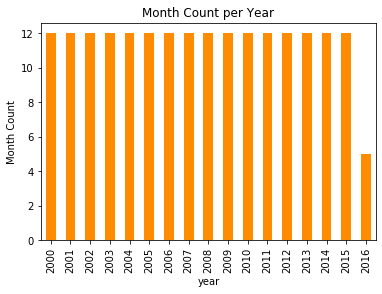

In [18]:
# Examine year month range
trim_data_group = trim_data.groupby(['year', 'month']).count()

trim_data_group = trim_data_group.reset_index(drop = False)

## Sort by Year and then month
trim_data_group = trim_data_group.sort_values(['year', 'month'])

# Visualize any missing months
year_month = trim_data_group[['year', 'month']]
year_month_group = year_month.groupby('year').count()
year_month_group = year_month_group.reset_index(drop = False)
year_month_group = year_month_group.rename(columns = {'month' : 'month_count'})

year_month_group.plot(kind = 'bar', x = 'year', y = 'month_count', color = 'darkorange', legend=None);
## Add chart details
plt.title('Month Count per Year');
plt.ylabel('Month Count');
### let's drop 2016 as it's a partial year in the dataset

In [33]:
# Drop 2016 Data due to partial year
trim_data = trim_data.loc[trim_data['year'] != 2016].copy()

# Create a Tidy Dataset
tidy_data = trim_data.copy()

# Save Tidy Data
tidy_data.to_csv('air_pollution_tidy.csv', index = False)

In [34]:
# Read Tidy Data back
tidy_data = pd.read_csv('air_pollution_tidy.csv')
tidy_data.tail()

,State,Date Local,NO2 Mean,year,month
403216,Wyoming,2015-12-27,9.456522,2015,12
403217,Wyoming,2015-12-28,13.200000,2015,12
403218,Wyoming,2015-12-29,10.045833,2015,12
403219,Wyoming,2015-12-30,7.047826,2015,12
403220,Wyoming,2015-12-31,2.445833,2015,12


### 

### Year-over-year NO2 Mean Values Analysis

In [35]:
# Year-over-year NO2 level Analysis

# Group data by years
group_data = tidy_data.groupby('year').mean()
## Reset index
group_data = group_data.reset_index(drop = False)

In [41]:
# Use .arange to make x values for the following charts/graphs
x_values = np.arange(group_data['year'].min(), group_data['year'].max() + 1, 1)
y_values = group_data['NO2 Mean']

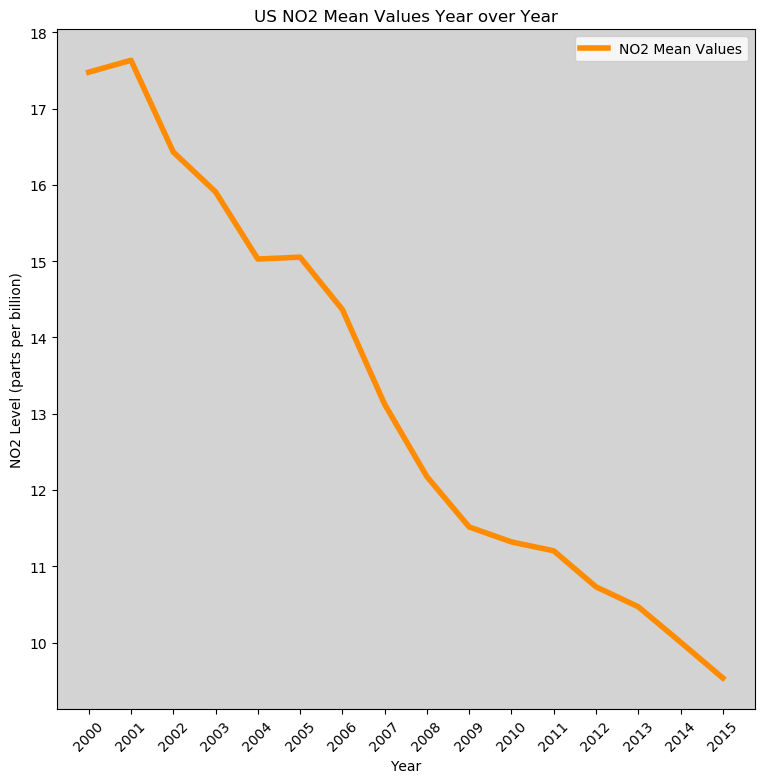

In [85]:
# Set up plot size
plt.figure(figsize = (9, 9), dpi = 100)
plt.axes(facecolor = 'lightgrey')

# Line graph for NO2 Mean Values
plt.plot(x_values, y_values, linewidth = 4, label = 'NO2 Mean Values', color = 'darkorange')
plt.title('US NO2 Mean Values Year over Year')
plt.xlabel('Year')
plt.ylabel('NO2 Level (parts per billion)')
plt.legend(loc = 'best')
plt.savefig('./us_no2_plot.png')
plt.xticks(ticks = x_values, rotation = 45)
plt.show()

The r-squared is: 0.9714764629547499
The p-value is 3.258674931817196e-12


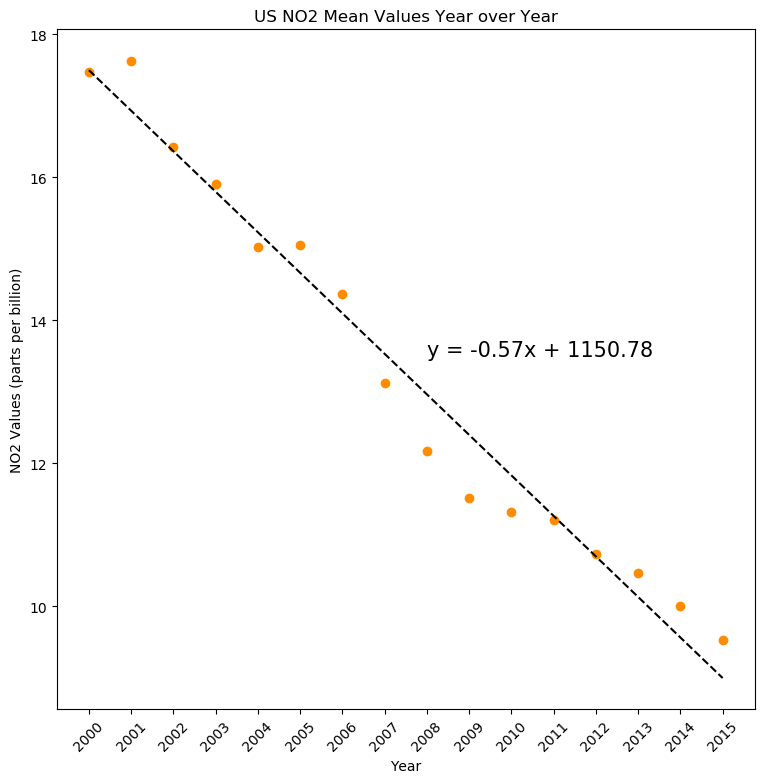

In [58]:
# Linear regression analysis for US NO2 Level
plt.figure(figsize = (9, 9), dpi = 100)
plt.scatter(x_values, y_values, color = 'darkorange')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values, regress_values, "--", color = 'black')
plt.annotate(line_eq, (2008, 13.5), fontsize = 15, color = "black")

plt.title('US NO2 Mean Values Year over Year')
plt.xlabel('Year')
plt.ylabel('NO2 Values (parts per billion)')
print(f"The r-squared is: {rvalue**2}")
print(f'The p-value is {pvalue}')
plt.savefig('./us_no2_plot_linregress.png')
plt.xticks(ticks = x_values, rotation = 45)
plt.show()

### Regional NO2 Mean Values Analysis

In [59]:
# Regional NO2 Mean Values Analysis

# Define each state's region
region_dict = {
    'Alabama':'South', 'Alaska':'West', 'Arizona':'West', 'Arkansas':'South', 'California':'West',
    'Colorado':'West', 'Connecticut':'Northeast', 'Delaware':'Northeast', 'District Of Columbia' : 'Northeast', 'Florida':'South',
    'Georgia':'South', 'Hawaii':'West', 'Idaho':'West', 'Illinois':'Midwest', 'Indiana':'Midwest', 'Iowa':'Midwest',
    'Kansas':'Midwest', 'Kentucky':'South', 'Louisiana':'South', 'Maine':'Northeast', 'Maryland':'South',
    'Massachusetts':'Northeast', 'Michigan':'Midwest', 'Minnesota':'Midwest', 'Mississippi':'South', 'Missouri':'Midwest',
    'Montana':'West', 'Nebraska':'Midwest', 'Nevada':'West', 'New Hampshire':'Northeast', 'New Jersey':'Northeast',
    'New Mexico':'West', 'New York':'Northeast', 'North Carolina':'South', 'North Dakota':'Midwest', 'Ohio':'Midwest',
    'Oklahoma':'South', 'Oregon':'West', 'Pennsylvania':'Northeast', 'Rhode Island':'Northeast', 'South Carolina':'South',
    'South Dakota':'Midwest','Tennessee':'South','Texas':'South','Utah':'West','Vermont':'Northeast',
    'Virginia':'South', 'Washington':'West', 'West Virginia':'South','Wisconsin':'Midwest','Wyoming':'West',
}


In [60]:
# Map Region into the dataframe
data_no2 = tidy_data.copy()
data_no2['Region'] = data_no2['State'].map(region_dict)

data_no2.head()

,State,Date Local,NO2 Mean,year,month,Region
0,Arizona,2000-01-01,19.041667,2000,1,West
1,Arizona,2000-01-02,22.958333,2000,1,West
2,Arizona,2000-01-03,38.125000,2000,1,West
3,Arizona,2000-01-04,40.260870,2000,1,West
4,Arizona,2000-01-05,48.450000,2000,1,West


In [61]:
# Create a DataFrame group by region and then year
grouped_region_yr = data_no2.groupby(['Region', 'year']).mean()
grouped_region_yr = grouped_region_yr.reset_index(drop = False)
grouped_region_yr.head()

,Region,year,NO2 Mean,month
0,Midwest,2000,17.600168,6.637634
1,Midwest,2001,17.009553,6.861739
2,Midwest,2002,15.432214,6.398291
3,Midwest,2003,15.678108,6.764981
4,Midwest,2004,14.031407,6.515785


In [62]:
# Visualization
northeast = grouped_region_yr.loc[grouped_region_yr['Region'] == 'Northeast'].copy()
midwest   = grouped_region_yr.loc[grouped_region_yr['Region'] == 'Midwest'].copy()
south     = grouped_region_yr.loc[grouped_region_yr['Region'] == 'South'].copy()
west      = grouped_region_yr.loc[grouped_region_yr['Region'] == 'West'].copy()

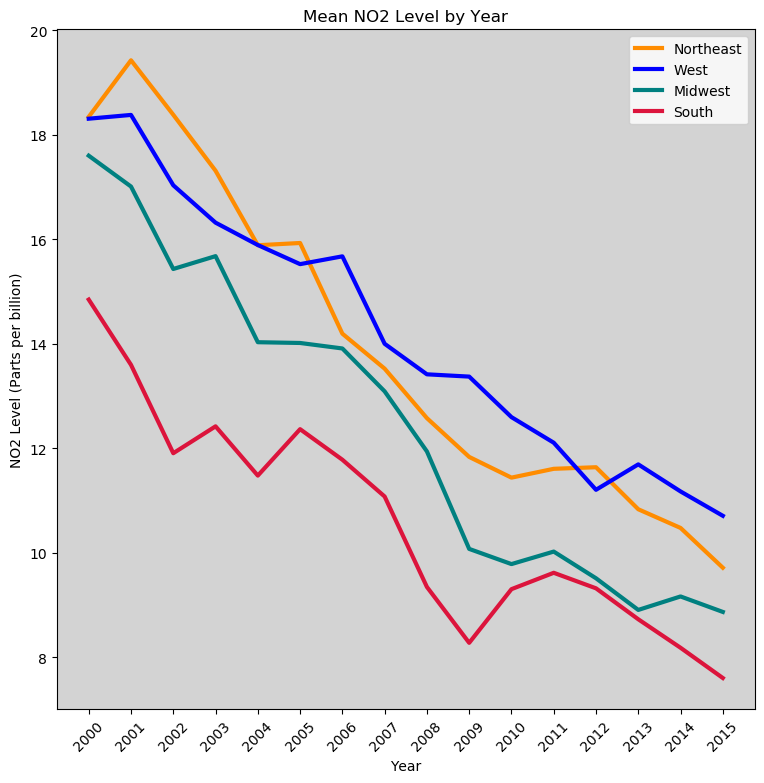

In [84]:
# Plotting the regional data
plt.figure(figsize = (9, 9), dpi = 100)
plt.axes(facecolor = 'lightgrey')

## Northeast
x = northeast['year']
y = northeast['NO2 Mean']
plt.plot(x, y, color = 'darkorange', linewidth = 3, label = 'Northeast')

## West
x1 = west['year']
y1 = west['NO2 Mean']
plt.plot(x1, y1, color = 'b', linewidth = 3, label = 'West')

## Midwest
x2 = midwest['year']
y2 = midwest['NO2 Mean']
plt.plot(x2, y2, color = 'teal', linewidth = 3, label = 'Midwest')

## South
x3 = south['year']
y3 = south['NO2 Mean']
plt.plot(x3, y3, color = 'crimson', linewidth = 3, label = 'South')

# Adding Plot Details
plt.title('Mean NO2 Level by Year')
plt.xlabel('Year')
plt.ylabel('NO2 Level (Parts per billion)')
plt.xticks(ticks = x, rotation = 45)

plt.legend();

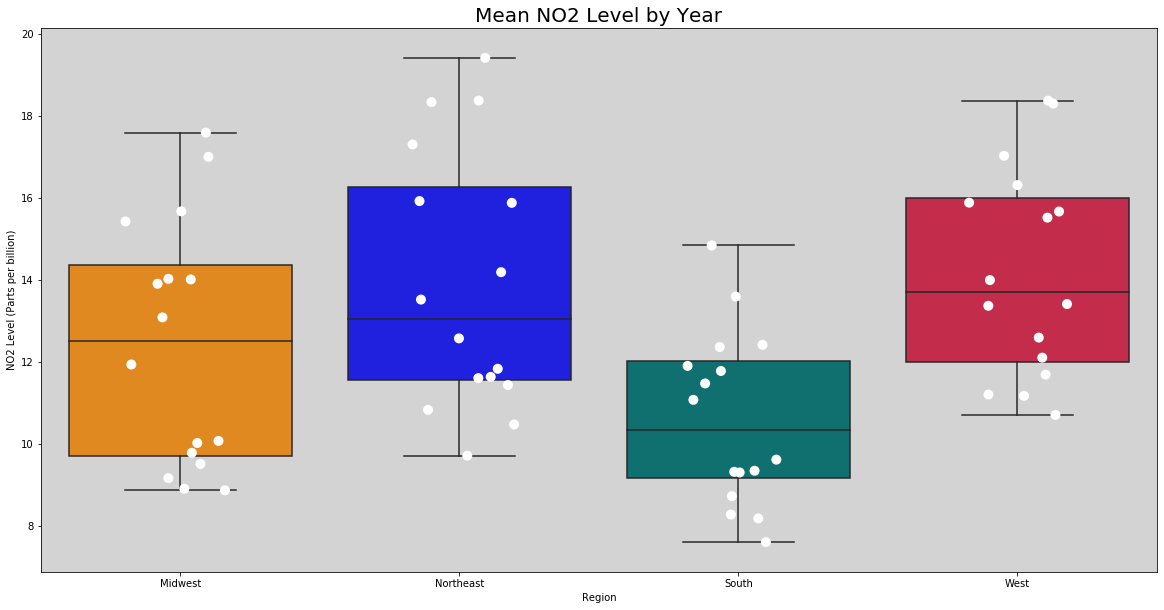

In [83]:
# Box plot visualization
plt.figure(figsize = (20, 10))
plt.axes(facecolor = 'lightgrey')

sns.boxplot(data = grouped_region_yr, x = 'Region', y = 'NO2 Mean',
            palette = ['darkorange', 'b', 'teal', 'crimson']);

sns.stripplot(data = grouped_region_yr, x = 'Region', y = 'NO2 Mean', color = 'white', jitter = .2, size = 10)

plt.ylabel('NO2 Level (Parts per billion)')
plt.title('Mean NO2 Level by Year', size = 20);

In [86]:
# One-way Anova test
stats.f_oneway(northeast["NO2 Mean"], midwest["NO2 Mean"], south["NO2 Mean"], west["NO2 Mean"])

F_onewayResult(statistic=5.773778859165822, pvalue=0.001547413038007804)

In [101]:
# collect NO2 mean from each region and drop the orginal index
northeast_no2mean = northeast["NO2 Mean"].reset_index(drop=True)
midwest_no2mean   = midwest["NO2 Mean"].reset_index(drop=True)
south_no2mean     = south["NO2 Mean"].reset_index(drop=True)
west_no2mean      = west["NO2 Mean"].reset_index(drop=True)

In [102]:
## check the assumptions for ANOVA (cite: https://reneshbedre.github.io/blog/anova.html)
# Shapiro-Wilk test (null hypotheis --data is drawn from normal distribution) p<0.05 reject the null hypothesis

# load packages
w, pvalue = stats.shapiro(northeast_no2mean)
print(w, pvalue)

# Bartlett’s test (Null hypothesis: samples from populations have equal variances) p<0.05 reject the null hypothesis
w, pvalue = stats.bartlett(northeast["NO2 Mean"], midwest["NO2 Mean"], south["NO2 Mean"], west["NO2 Mean"])
print(w, pvalue)

0.9127888083457947 0.12906821072101593
2.8035652802151314 0.422913344696226


In [114]:
# Comparing Northeast vs Midwes
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(northeast["NO2 Mean"], midwest["NO2 Mean"], equal_var=False)

print(statistic, pvalue)

1.3708468346414378 0.18061440186278355


In [108]:
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(northeast["NO2 Mean"], south["NO2 Mean"], equal_var=False)
print(statistic, pvalue)

Ttest_indResult(statistic=3.489148473641476, pvalue=0.001735853769172573)

In [109]:
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(northeast["NO2 Mean"], west["NO2 Mean"], equal_var=False)
print(statistic, pvalue)

Ttest_indResult(statistic=-0.26242350218560295, pvalue=0.7948684300018172)

In [110]:
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(midwest["NO2 Mean"], south["NO2 Mean"], equal_var=False)

print(statistic, pvalue)

Ttest_indResult(statistic=1.9742699650401772, pvalue=0.05873607300052589)

In [111]:
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(midwest["NO2 Mean"], west["NO2 Mean"], equal_var=False)

print(statistic, pvalue)

Ttest_indResult(statistic=-1.7861907316881236, pvalue=0.08445958207354541)

In [112]:
# Calculate Independent (Two Sample) T-Test
statistic, pvalue = stats.ttest_ind(south["NO2 Mean"], west["NO2 Mean"], equal_var=False)

print(statistic, pvalue)

Ttest_indResult(statistic=-4.329446337007264, pvalue=0.00016291335828065644)

In [ ]:
pair=["northeast vs midwest", "northeast vs south", "northeast vs west", "midwest vs south", "midwest vs west", "south vs west"]
statistic=["5.707134902561668","8.640070134972966", "2.262539092415285", "4.151950943880369", "-3.658447211505495", "-7.038294511879622"]
pvalue=["2.6945773000790913e-08", "2.7577358126904945e-16", "0.02424655905406459", "4.071034264173572e-05","0.00029325701539204577","1.009126518355953e-11"]
interpretation=["Reject null hypothesis", "Reject null hypothesis", "Reject null hypothesis", "Reject null hypothesis", "Reject null hypothesis", "Reject null hypothesis"]
stats_table=pd.DataFrame({"Pair": pair, "Statistic": statistic, "pvalue": pvalue, "Interpretation ": interpretation})
stats_table

In [ ]:
# # let's try monthly

# data_no2['month'] = data_no2['Date Local'].str[5:7]

# data_no2['yearmonth'] = data_no2['year'].astype(str) + data_no2['month'].astype(str)

# data_no2.head()

# # groupby region, year, month

# gby_region_yrmo = data_no2.groupby(['Region', 'yearmonth']).mean()

# gby_region_yrmo = gby_region_yrmo.reset_index( drop = False)

# northeast = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'Northeast'].copy()
# midwest = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'Midwest'].copy()
# south = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'South'].copy()
# west = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'West'].copy()

# # west.plot(kind = 'line', x = 'year', y = 'NO2 Mean')
# # northeast.plot(kind = 'line', x = 'year', y = 'NO2 Mean', color = 'darkorange')

# plt.figure(figsize = (9, 9), dpi = 100)

# x = west['yearmonth']
# y = west['NO2 Mean']

# plt.plot(x, y, color = 'b', label = 'West')

# # x1 = northeast['yearmonth']
# # y1 = northeast['NO2 Mean']

# # plt.plot(x1, y1, color = 'darkorange', label = 'Northeast')

# x2 = south['yearmonth']
# y2 = south['NO2 Mean']

# plt.plot(x2, y2, color = 'crimson', label = 'South')

# # x3 = midwest['yearmonth']
# # y3 = midwest['NO2 Mean']

# # plt.plot(x3, y3, color = 'teal', label = 'Midwest')

# plt.title('Mean NO2 Level by Month')
# plt.xlabel('yearmonth')
# plt.ylabel('NO2 Level (Parts per billion)')
# plt.xticks(ticks = x)

# plt.legend();
# plt.show()